In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración para reproducibilidad
np.random.seed(42)

In [2]:
data = pd.read_csv("data_mlp.csv")

In [3]:
print("Estadísticas del dataset:")
print(data.describe())
print(f"\nForma de los datos: {data.shape}")

Estadísticas del dataset:
           Sample          x1          x2          x3           d
count  200.000000  200.000000  200.000000  200.000000  200.000000
mean   100.500000    0.500101    0.491556    0.482272    0.624440
std     57.879185    0.306622    0.303002    0.284523    0.180872
min      1.000000    0.000000    0.000000    0.000000    0.085100
25%     50.750000    0.240325    0.209325    0.252475    0.492900
50%    100.500000    0.472850    0.532300    0.462600    0.627250
75%    150.250000    0.786375    0.757075    0.697900    0.771275
max    200.000000    1.000000    1.000000    1.000000    0.990400

Forma de los datos: (200, 5)


In [4]:
# Separar features y target
X = data[['x1', 'x2', 'x3']].values
y = data['d'].values

In [5]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nConjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")


Conjunto de entrenamiento: 160 muestras
Conjunto de prueba: 40 muestras


In [6]:
# =============================================================================
# SECCIÓN 2: HIPERPARÁMETROS CONFIGURABLES
# =============================================================================

# ¡EXPERIMENTA AQUÍ! Cambia estos valores para explorar
HYPERPARAMS = {
    'hidden_layers': (10,),  # Tupla: (10,) = 1 capa con 10 neuronas
                              #         (10, 5) = 2 capas con 10 y 5 neuronas
    'activation': 'logistic',     # Opciones: 'relu', 'tanh', 'logistic' logistic satisface sigmoid 
    'learning_rate': 0.1, #tasa de aprendizaje n = 0.1 como lo especifica el punto 1 del ejercicio 
    'max_iter': 1000,
    'solver': 'adam',         # Opciones: 'adam', 'sgd', 'lbfgs'
    'alpha': 0.0001,          # Regularización L2
    'batch_size': 32,
    
    # CRITERIOS DE CONVERGENCIA
    'tol': 1e-6,              # ε: Tolerancia mínima de mejora como lo especifica el punto 1 
    'n_iter_no_change': 10,   # Iteraciones sin mejora antes de parar
    'early_stopping': True,   # Usar conjunto de validación para parar
    'validation_fraction': 0.1, # % de datos para early stopping
}

print("\n" + "="*60)
print("CONFIGURACIÓN ACTUAL:")
print("="*60)
for key, value in HYPERPARAMS.items():
    print(f"{key:20s}: {value}")
print("="*60)


CONFIGURACIÓN ACTUAL:
hidden_layers       : (10,)
activation          : logistic
learning_rate       : 0.1
max_iter            : 1000
solver              : adam
alpha               : 0.0001
batch_size          : 32
tol                 : 1e-06
n_iter_no_change    : 10
early_stopping      : True
validation_fraction : 0.1


In [7]:
# =============================================================================
# SECCIÓN 3: IMPLEMENTACIÓN SIMPLE (Forward Pass)
# =============================================================================

class SimpleMLPRegressor:
    """
    MLP simple para entender el flujo de datos.
    Solo forward pass - útil para visualizar transformaciones.
    """
    
    def __init__(self, input_size, hidden_size, output_size=1):
        # Inicialización de pesos (Xavier/Glorot)
        limit1 = np.sqrt(6 / (input_size + hidden_size))
        self.W1 = np.random.uniform(-limit1, limit1, (input_size, hidden_size))
        self.b1 = np.zeros((1, hidden_size))
        
        limit2 = np.sqrt(6 / (hidden_size + output_size))
        self.W2 = np.random.uniform(-limit2, limit2, (hidden_size, output_size))
        self.b2 = np.zeros((1, output_size))
    
    def relu(self, x):
        """ReLU: max(0, x)"""
        return np.maximum(0, x)
    
    def forward(self, X):
        """
        Forward pass completo.
        Retorna predicción final y activaciones intermedias.
        """
        # Capa oculta
        self.z1 = X @ self.W1 + self.b1  # Combinación lineal
        self.a1 = self.relu(self.z1)      # Activación
        
        # Capa de salida (sin activación - lineal)
        self.z2 = self.a1 @ self.W2 + self.b2
        
        return self.z2, self.a1  # Predicción y activaciones ocultas
    
    def predict(self, X):
        """Predicción simple"""
        pred, _ = self.forward(X)
        return pred.flatten()

# Crear modelo simple
simple_model = SimpleMLPRegressor(
    input_size=3, 
    hidden_size=HYPERPARAMS['hidden_layers'][0]
)

# Predicciones antes de entrenar (aleatorias)
y_pred_before, activations_before = simple_model.forward(X_test)
print(f"\nPredicciones aleatorias (antes de entrenar):")
print(f"Rango: [{y_pred_before.min():.3f}, {y_pred_before.max():.3f}]")
print(f"MSE inicial: {mean_squared_error(y_test, y_pred_before):.4f}")


Predicciones aleatorias (antes de entrenar):
Rango: [-1.008, 0.162]
MSE inicial: 1.2138


In [14]:
# =============================================================================
# SECCIÓN 4: SKLEARN MLPRegressor (Implementación Completa) entrena una sola vez 
# =============================================================================

print("\n" + "="*60)
print("ENTRENANDO CON SKLEARN...")
print("="*60)

mlp = MLPRegressor(
    hidden_layer_sizes=HYPERPARAMS['hidden_layers'],
    activation=HYPERPARAMS['activation'],
    solver=HYPERPARAMS['solver'],
    alpha=HYPERPARAMS['alpha'],
    batch_size=HYPERPARAMS['batch_size'],
    learning_rate_init=HYPERPARAMS['learning_rate'],
    max_iter=HYPERPARAMS['max_iter'],
    tol=HYPERPARAMS['tol'],
    n_iter_no_change=HYPERPARAMS['n_iter_no_change'],
    early_stopping=HYPERPARAMS['early_stopping'],
    validation_fraction=HYPERPARAMS['validation_fraction'],
    random_state=42,
    verbose=False
)

mlp.fit(X_train, y_train)

# Predicciones
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)


ENTRENANDO CON SKLEARN...


In [17]:

print("\n" + "="*60)
print("ENTRENANDO 5 VECES Y GUARDANDO CURVAS DE APRENDIZAJE...")
print("="*60)

# Lista para almacenar resultados y curvas
resultados = []
curvas_aprendizaje = []

for i in range(5):
    print(f"\nEntrenamiento {i+1}/5 (seed={42+i})...")
    
    # Crear modelo con semilla diferente
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=HYPERPARAMS['hidden_layers'],
        activation=HYPERPARAMS['activation'],
        solver=HYPERPARAMS['solver'],
        alpha=HYPERPARAMS['alpha'],
        batch_size=HYPERPARAMS['batch_size'],
        learning_rate_init=HYPERPARAMS['learning_rate'],
        max_iter=HYPERPARAMS['max_iter'],
        tol=HYPERPARAMS['tol'],
        n_iter_no_change=HYPERPARAMS['n_iter_no_change'],
        early_stopping=HYPERPARAMS['early_stopping'],
        validation_fraction=HYPERPARAMS['validation_fraction'],
        random_state=42 + i,
        verbose=False
    )
    
    # Entrenar
    mlp_temp.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred_temp = mlp_temp.predict(X_train)
    y_test_pred_temp = mlp_temp.predict(X_test)
    
    # Calcular métricas
    mse_train = mean_squared_error(y_train, y_train_pred_temp)
    mse_test = mean_squared_error(y_test, y_test_pred_temp)
    
    # Almacenar resultados
    resultados.append({
        'Ejecucion': i + 1,
        'Seed': 42 + i,
        'MSE_Train': mse_train,
        'MSE_Test': mse_test,
        'Num_Epocas': mlp_temp.n_iter_,
        'R2_Train': r2_score(y_train, y_train_pred_temp),
        'R2_Test': r2_score(y_test, y_test_pred_temp)
    })
    
    # Guardar curva de aprendizaje si existe
    if hasattr(mlp_temp, 'loss_curve_'):
        curvas_aprendizaje.append({
            'ejecucion': i + 1,
            'seed': 42 + i,
            'curva': mlp_temp.loss_curve_.copy(),
            'n_epocas': mlp_temp.n_iter_
        })
    
    print(f"  MSE Test: {mse_test:.6f} | Épocas: {mlp_temp.n_iter_}")

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Encontrar los 2 entrenamientos con mayor número de épocas
top_2_idx = df_resultados.nlargest(2, 'Num_Epocas').index
top_2_ejecuciones = df_resultados.loc[top_2_idx, 'Ejecucion'].values

print("\n" + "="*60)
print("RESULTADOS DE LAS 5 EJECUCIONES")
print("="*60)
print(df_resultados.to_string(index=False))

print("\n" + "="*60)
print(f"Los 2 entrenamientos con mayor número de épocas son:")
print(f"  Ejecución {top_2_ejecuciones[0]}: {df_resultados.loc[top_2_idx[0], 'Num_Epocas']} épocas")
print(f"  Ejecución {top_2_ejecuciones[1]}: {df_resultados.loc[top_2_idx[1], 'Num_Epocas']} épocas")
print("="*60)


ENTRENANDO 5 VECES Y GUARDANDO CURVAS DE APRENDIZAJE...

Entrenamiento 1/5 (seed=42)...
  MSE Test: 0.001955 | Épocas: 26

Entrenamiento 2/5 (seed=43)...
  MSE Test: 0.001726 | Épocas: 40

Entrenamiento 3/5 (seed=44)...
  MSE Test: 0.002281 | Épocas: 27

Entrenamiento 4/5 (seed=45)...
  MSE Test: 0.001624 | Épocas: 46

Entrenamiento 5/5 (seed=46)...
  MSE Test: 0.001792 | Épocas: 79

RESULTADOS DE LAS 5 EJECUCIONES
 Ejecucion  Seed  MSE_Train  MSE_Test  Num_Epocas  R2_Train  R2_Test
         1    42   0.001401  0.001955          26  0.956039 0.944581
         2    43   0.001082  0.001726          40  0.966054 0.951087
         3    44   0.001409  0.002281          27  0.955786 0.935367
         4    45   0.001025  0.001624          46  0.967842 0.953967
         5    46   0.001084  0.001792          79  0.965987 0.949217

Los 2 entrenamientos con mayor número de épocas son:
  Ejecución 5: 79 épocas
  Ejecución 4: 46 épocas


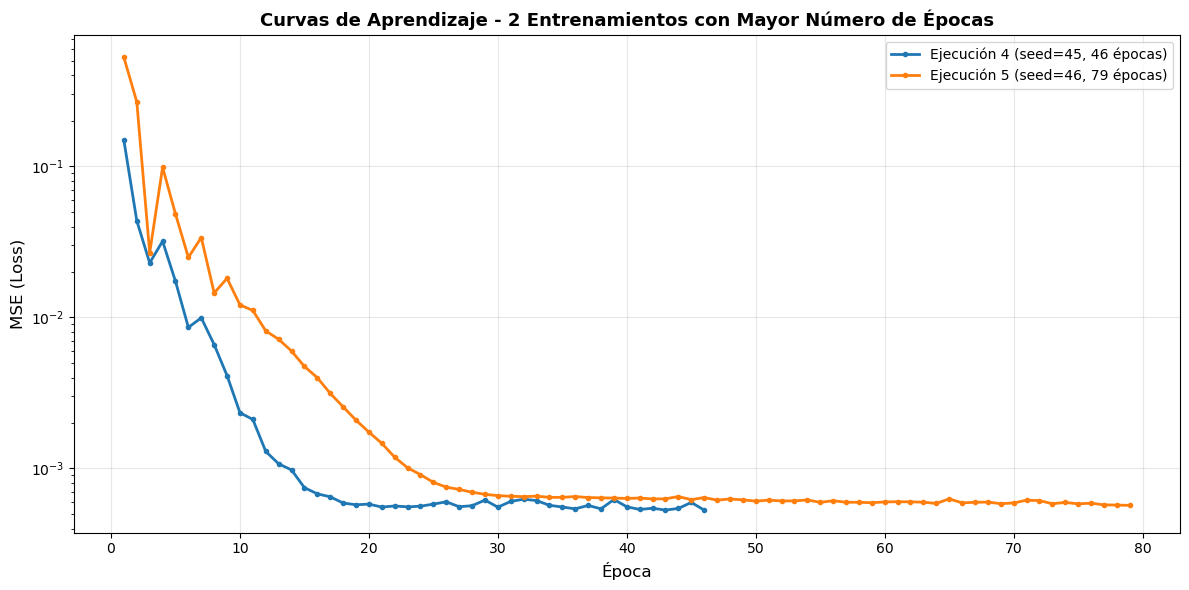


ESTADÍSTICAS RESUMEN

MSE Test:
  Promedio: 0.001876
  Desv. Est: 0.000256
  Mínimo: 0.001624
  Máximo: 0.002281

Número de Épocas:
  Promedio: 43.6
  Mínimo: 26
  Máximo: 79


In [18]:

# Graficar curvas de aprendizaje de los 2 mejores
plt.figure(figsize=(12, 6))

for curva_info in curvas_aprendizaje:
    if curva_info['ejecucion'] in top_2_ejecuciones:
        epocas = range(1, len(curva_info['curva']) + 1)
        label = f"Ejecución {curva_info['ejecucion']} (seed={curva_info['seed']}, {curva_info['n_epocas']} épocas)"
        plt.plot(epocas, curva_info['curva'], linewidth=2, label=label, marker='o', markersize=3)

plt.xlabel('Época', fontsize=12)
plt.ylabel('MSE (Loss)', fontsize=12)
plt.title('Curvas de Aprendizaje - 2 Entrenamientos con Mayor Número de Épocas', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.tight_layout()
plt.show()

# Estadísticas resumen
print("\n" + "="*60)
print("ESTADÍSTICAS RESUMEN")
print("="*60)
print(f"\nMSE Test:")
print(f"  Promedio: {df_resultados['MSE_Test'].mean():.6f}")
print(f"  Desv. Est: {df_resultados['MSE_Test'].std():.6f}")
print(f"  Mínimo: {df_resultados['MSE_Test'].min():.6f}")
print(f"  Máximo: {df_resultados['MSE_Test'].max():.6f}")

print(f"\nNúmero de Épocas:")
print(f"  Promedio: {df_resultados['Num_Epocas'].mean():.1f}")
print(f"  Mínimo: {df_resultados['Num_Epocas'].min()}")
print(f"  Máximo: {df_resultados['Num_Epocas'].max()}")

In [13]:
# =============================================================================
# SECCIÓN 5: EVALUACIÓN
# =============================================================================

def evaluar_modelo(y_true, y_pred, conjunto=""):
    """Calcula métricas de regresión"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{conjunto}:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

print("\n" + "="*60)
print("MÉTRICAS DE EVALUACIÓN")
print("="*60)

metrics_train = evaluar_modelo(y_train, y_train_pred, "ENTRENAMIENTO")
metrics_test = evaluar_modelo(y_test, y_test_pred, "PRUEBA")

# Análisis de overfitting
diff_r2 = metrics_train['r2'] - metrics_test['r2']
print(f"\n{'='*60}")
print(f"Diferencia R² (train - test): {diff_r2:.4f}")
if diff_r2 > 0.1:
    print("  Posible overfitting - considera regularización")
elif diff_r2 < 0:
    print("  Modelo puede estar underfitting")
else:
    print(" Generalización aceptable")


MÉTRICAS DE EVALUACIÓN

ENTRENAMIENTO:
  MSE:  0.001401
  RMSE: 0.037429
  MAE:  0.032672
  R²:   0.956039

PRUEBA:
  MSE:  0.001955
  RMSE: 0.044220
  MAE:  0.036289
  R²:   0.944581

Diferencia R² (train - test): 0.0115
 Generalización aceptable


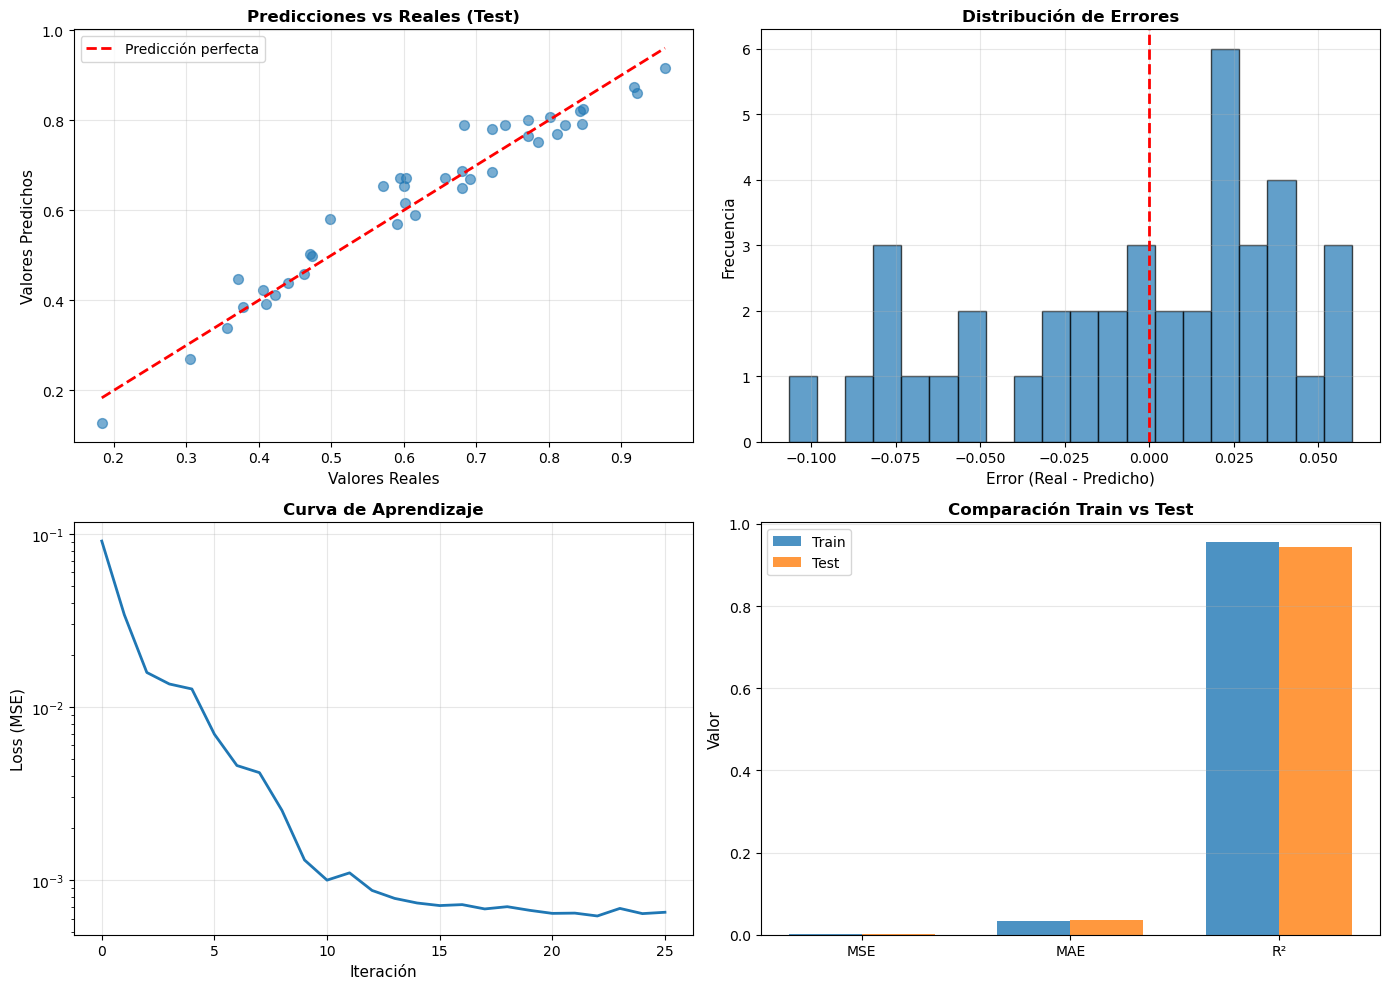

In [10]:

# =============================================================================
# SECCIÓN 6: VISUALIZACIONES
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Valores reales vs predichos
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, s=50)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Predicción perfecta')
axes[0, 0].set_xlabel('Valores Reales', fontsize=11)
axes[0, 0].set_ylabel('Valores Predichos', fontsize=11)
axes[0, 0].set_title('Predicciones vs Reales (Test)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Distribución de errores
residuals = y_test - y_test_pred
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Error (Real - Predicho)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución de Errores', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Curva de aprendizaje
if hasattr(mlp, 'loss_curve_'):
    axes[1, 0].plot(mlp.loss_curve_, lw=2)
    axes[1, 0].set_xlabel('Iteración', fontsize=11)
    axes[1, 0].set_ylabel('Loss (MSE)', fontsize=11)
    axes[1, 0].set_title('Curva de Aprendizaje', fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].set_yscale('log')

# 4. Comparación métricas train vs test
metrics_names = ['MSE', 'MAE', 'R²']
train_values = [metrics_train['mse'], metrics_train['mae'], metrics_train['r2']]
test_values = [metrics_test['mse'], metrics_test['mae'], metrics_test['r2']]

x_pos = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x_pos - width/2, train_values, width, label='Train', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, test_values, width, label='Test', alpha=0.8)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].set_ylabel('Valor', fontsize=11)
axes[1, 1].set_title('Comparación Train vs Test', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [11]:
# =============================================================================
# SECCIÓN 7: ANÁLISIS DE LA ARQUITECTURA
# =============================================================================

print("\n" + "="*60)
print("INFORMACIÓN DE LA ARQUITECTURA")
print("="*60)

print(f"\nNúmero de capas: {mlp.n_layers_}")
print(f"Número de salidas: {mlp.n_outputs_}")
print(f"Función de activación: {mlp.activation}")
print(f"Iteraciones realizadas: {mlp.n_iter_}")

print("\nForma de los pesos por capa:")
for i, (coef, intercept) in enumerate(zip(mlp.coefs_, mlp.intercepts_)):
    print(f"  Capa {i+1}: W{i+1} = {coef.shape}, b{i+1} = {intercept.shape}")

# Total de parámetros
total_params = sum(w.size for w in mlp.coefs_) + sum(b.size for b in mlp.intercepts_)
print(f"\nTotal de parámetros entrenables: {total_params}")
print(f"Ratio muestras/parámetros: {len(X_train)/total_params:.2f}")


INFORMACIÓN DE LA ARQUITECTURA

Número de capas: 3
Número de salidas: 1
Función de activación: logistic
Iteraciones realizadas: 26

Forma de los pesos por capa:
  Capa 1: W1 = (3, 10), b1 = (10,)
  Capa 2: W2 = (10, 1), b2 = (1,)

Total de parámetros entrenables: 51
Ratio muestras/parámetros: 3.14


In [12]:
# =============================================================================
# SECCIÓN 8: PREGUNTAS PARA REFLEXIONAR
# =============================================================================

print("\n" + "="*60)
print("PREGUNTAS PARA EXPERIMENTAR")
print("="*60)
print("""
1. ¿Qué pasa si cambias 'relu' por 'tanh' o 'logistic'?
   → Modifica HYPERPARAMS['activation']

2. ¿Cómo afecta el número de neuronas en la capa oculta?
   → Prueba (5,), (20,), (50,)

3. ¿Y si agregas una segunda capa oculta?
   → Prueba (10, 5) o (20, 10)

4. ¿Qué pasa con learning_rate muy bajo (0.0001) o alto (0.01)?

5. ¿Observas overfitting? ¿Cómo lo solucionarías?
   → Aumenta 'alpha' (regularización)
   → Reduce número de neuronas
   → Más datos de entrenamiento

6. Observa la curva de aprendizaje:
   → ¿Converge?
   → ¿Se estabiliza o sigue bajando?
   → ¿Necesitas más iteraciones?
""")

print("\n¡Listo para experimentar! Modifica HYPERPARAMS y vuelve a ejecutar.")


PREGUNTAS PARA EXPERIMENTAR

1. ¿Qué pasa si cambias 'relu' por 'tanh' o 'logistic'?
   → Modifica HYPERPARAMS['activation']

2. ¿Cómo afecta el número de neuronas en la capa oculta?
   → Prueba (5,), (20,), (50,)

3. ¿Y si agregas una segunda capa oculta?
   → Prueba (10, 5) o (20, 10)

4. ¿Qué pasa con learning_rate muy bajo (0.0001) o alto (0.01)?

5. ¿Observas overfitting? ¿Cómo lo solucionarías?
   → Aumenta 'alpha' (regularización)
   → Reduce número de neuronas
   → Más datos de entrenamiento

6. Observa la curva de aprendizaje:
   → ¿Converge?
   → ¿Se estabiliza o sigue bajando?
   → ¿Necesitas más iteraciones?


¡Listo para experimentar! Modifica HYPERPARAMS y vuelve a ejecutar.
